In [1]:
# from diffusers.utils import randn_tensor

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [3]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [4]:
from datasets import load_dataset

In [6]:
import pickle

In [7]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [8]:
# with open('./data/indices/5000-0.5/idx-val.pkl', 'rb')  as handle:
#     idx_val = pickle.load(handle)
# len(idx_val)

In [9]:
import pandas as pd
df = pd.read_csv('../../../../codes/celeba/data/celeba/list_eval_partition.txt', delimiter=" ", 
                 names=['path', 'split'],
                 header=None, skipinitialspace=True)
df['path'] = df.apply(lambda x: "../../../../codes/celeba/data/celeba/img_align_celeba/{}".format(x['path']), axis=1)
df.head()    

,path,split
0,../../../../codes/celeba/data/celeba/img_align...,0
1,../../../../codes/celeba/data/celeba/img_align...,0
2,../../../../codes/celeba/data/celeba/img_align...,0
3,../../../../codes/celeba/data/celeba/img_align...,0
4,../../../../codes/celeba/data/celeba/img_align...,0


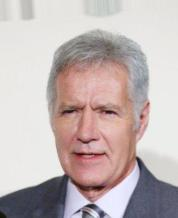

In [10]:
from datasets import Dataset, load_dataset, Image

train_dataset = Dataset.from_dict({"img": df.loc[idx_train]['path'].tolist(),
                                  }).cast_column("img", Image())
train_dataset[0]["img"]

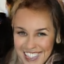

In [11]:
import pandas as pd
df = pd.DataFrame()
df['path'] = ['{}/{}.png'.format('../../saved/5000-0.5/gen', i) for i in range(1000)]

from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": df['path'].tolist(),
}).cast_column("img", Image()),})
val_dataset = dataset["train"]
val_dataset[0]["img"]

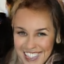

In [12]:
val_dataset[0]['img']

In [13]:
# val_dataset =  dataset['test'].select(idx_val)
# val_dataset[0]["img"]

In [14]:
# idx_val[0:5]

In [15]:
class Args():
            
    dataset_name="cifar10"

    output_dir="../../saved/5000-0.5/retrain"
    
    # project_dim=3584
    project_dim=65536

    # used_dim=3584
    # used_dim=16384
    used_dim=32768

    strategy='uniform'
    # strategy='cumulative'
   
args = Args()

In [16]:
import diffusers
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.optimization import get_scheduler

In [17]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [18]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-gen.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

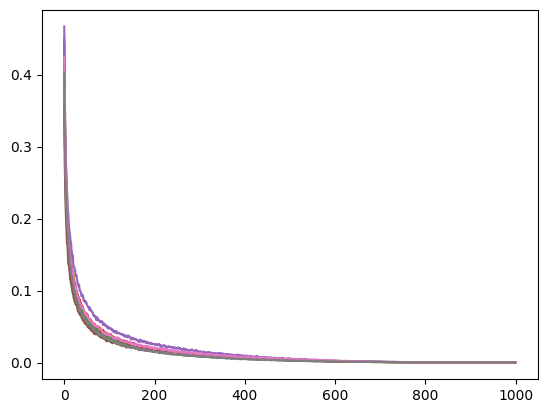

In [19]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [20]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [21]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

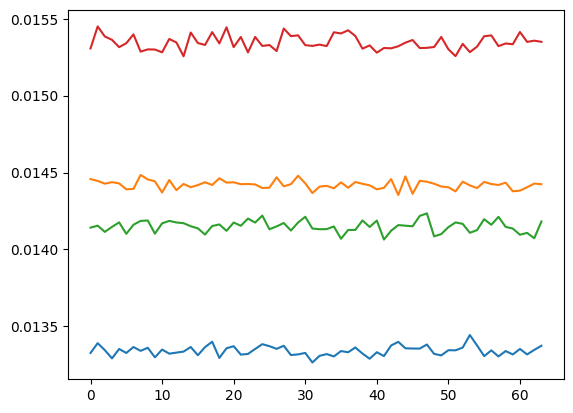

In [22]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [23]:
from scipy.stats import spearmanr, pearsonr
f_name_list = [
    'loss', 
    ####
    # 'mean',
    'mean-squared-l2-norm', 
    ####
    # 'l1_norm',
    # 'l2_norm',
    # 'linf_norm'
    ####
]


lamb_list = [
        # 0,

        1e-2, 2e-2, 5e-2,
        1e-1, 2e-1, 5e-1,
        1e0, 2e0, 5e0,
        1e1, 2e1, 5e1,
        1e2, 2e2, 5e2,
        1e3, 2e3, 5e3, 
        1e4, 2e4, 5e4, 
        1e5, 2e5, 5e5, 
        1e6, 2e6, 5e6, 
    
        # 1e7, 2e7, 5e7,
        # 1e8, 2e8, 5e8,
        # 1e9, 2e9, 5e9,
        # 1e10, 2e10, 5e10, 
        # 1e11, 2e11, 5e11,
        # 1e12
    ]

print(len(lamb_list))


ckpt_list = [
    0, 1, 
    2, 3, 4, 5, 6, 7, 
    # 8
            ]

27


In [24]:
# for loop over functions
seed_lds_list = []

seed_score_list = []

for num_seed in [
    1, 
    # 2, 3, 4, 5
]:
    print(num_seed)
    f_lds_list = []

    f_score_list = []
    
    for f in f_name_list:
        ####
        print(f)
        
        lds_list = []
        
        score_list = []
        
        K = 10
        for ckpt in ckpt_list:
            print(ckpt)
            ####
            dstore_keys_list = []
            for split in range(5):
                tmp = None
                for e_seed in range(num_seed):
                    dstore_keys = np.memmap('{}/ddpm-sub-{}-0/features-{}/ddpm-train-keys-{}-{}-{}-{}-{}.npy'.format(
                        args.output_dir, ckpt, e_seed,
                        split, K, args.project_dim, f, args.strategy), 
                                        dtype=np.float32, 
                                        mode='r',
                                        shape=(1000, args.project_dim))
                    dstore_keys = dstore_keys[:, :args.used_dim]
                    if e_seed==0:
                        tmp = dstore_keys.copy()
                    else:
                        tmp += dstore_keys
                tmp = tmp/num_seed
                dstore_keys_list.append(tmp) 
            
            dstore_keys = np.vstack(dstore_keys_list)
            print(dstore_keys.shape)  
            
            if f=='l1_norm':
                dstore_keys = dstore_keys / 3072
            elif f=='l2_norm':
                dstore_keys = dstore_keys / (3072**0.5)
            ####    
            tmp = None
            for e_seed in range(num_seed):
                gen_dstore_keys = np.memmap('{}/ddpm-sub-{}-0/features-{}/ddpm-gen-keys-{}-{}-{}-{}-{}.npy'.format(
                       args.output_dir, ckpt, e_seed, 
                    0, K, args.project_dim, f, args.strategy), 
                                    dtype=np.float32, 
                                    mode='r',
                                    shape=(1000, args.project_dim))
                gen_dstore_keys = gen_dstore_keys[:, :args.used_dim]
                if e_seed==0:
                    tmp = gen_dstore_keys.copy()
                else:
                    tmp += gen_dstore_keys
            tmp = tmp/num_seed
            gen_dstore_keys = tmp
            print(gen_dstore_keys.shape)
            if f=='l1_norm':
                gen_dstore_keys = gen_dstore_keys / 3072
            elif f=='l2_norm':
                gen_dstore_keys = gen_dstore_keys / (3072**0.5)
            ####
            dstore_keys = torch.from_numpy(dstore_keys).cuda()
            gen_dstore_keys = torch.from_numpy(gen_dstore_keys).cuda()
            ####
            # if f=='l1_norm':
            #     dstore_keys = dstore_keys/3072
            #     gen_dstore_keys = gen_dstore_keys/3072
            ####
            kernel = dstore_keys.T@dstore_keys
            ####
            rs_list = []
            ps_list = []

            best_scores = None
            best_lds = -np.inf
            for lamb in lamb_list:
                print(lamb)
                # kernel_ = kernel + lamb*np.eye(kernel.shape[0])
                kernel_ = kernel + lamb*torch.eye(kernel.shape[0]).cuda()
                # kernel_ = torch.from_numpy(kernel_).cuda()
                ####
                kernel_ = torch.linalg.inv(kernel_)  
                # kernel_ = kernel_.cpu().numpy()
                ####
                print(kernel_.shape)
                print(torch.mean(kernel_.diagonal()))
                ####
                # scores = gen_dstore_keys.dot((dstore_keys@kernel_).T)
                scores = gen_dstore_keys@((dstore_keys@kernel_).T)
                print(scores.size())
                scores = scores.cpu().numpy()
    
                # compute lds
                margins = lds_testset_correctness
                infl_est_ = -scores
                preds = lds_mask_array @ infl_est_.T
                ####
                rs = []
                ps = []
    
                for ind in range(1000):
                   r, p = spearmanr(preds[:, ind], margins[:, ind])
                   # r, p = pearsonr(preds[:, ind], margins[:, ind])
                   rs.append(r)
                   ps.append(p)
        
                rs, ps = np.array(rs), np.array(ps)
                print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')
    
                rs_list.append(rs.mean())   
                ps_list.append(ps.mean())
                
                if rs.mean()>best_lds:
                    best_scores = scores
                    best_lds = rs.mean()
                    
            lds_list.append((rs_list, ps_list))
            score_list.append(best_scores)
            
        f_lds_list.append(lds_list)
        f_score_list.append(score_list)
    seed_lds_list.append(f_lds_list)
    seed_score_list.append(f_score_list)

1
loss
0
(5000, 32768)
(1000, 32768)
0.01
torch.Size([32768, 32768])
tensor(71.9578, device='cuda:0')
torch.Size([1000, 5000])
Correlation: -0.006 (avg p value 0.516459)
0.02
torch.Size([32768, 32768])
tensor(51.9109, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.002 (avg p value 0.499082)
0.05
torch.Size([32768, 32768])
tensor(17.4136, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.069 (avg p value 0.448504)
0.1
torch.Size([32768, 32768])
tensor(8.5325, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.069 (avg p value 0.446600)
0.2
torch.Size([32768, 32768])
tensor(4.2473, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.069 (avg p value 0.447561)
0.5
torch.Size([32768, 32768])
tensor(1.6983, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.069 (avg p value 0.447228)
1.0
torch.Size([32768, 32768])
tensor(0.8503, device='cuda:0')
torch.Size([1000, 5000])
Correlation: 0.069 (avg p value 0.447292)
2.0
torch.Size([32768, 32768])
tensor(0.4265, 

In [25]:
seed_lds_array = np.array(seed_lds_list)
seed_lds_array[0]

array([[[[-6.40214801e-03,  2.02809761e-03,  6.87005196e-02,
           6.87962623e-02,  6.88388909e-02,  6.90540696e-02,
           6.91708510e-02,  6.95142578e-02,  7.06646468e-02,
           7.25850920e-02,  7.44328725e-02,  7.80197323e-02,
           8.17407955e-02,  8.53499531e-02,  9.00150852e-02,
           9.32236257e-02,  9.46833557e-02,  9.48165733e-02,
           9.19480755e-02,  8.54577084e-02,  7.39167477e-02,
           6.36333916e-02,  5.47787876e-02,  4.68442854e-02,
           4.41966640e-02,  4.28358143e-02,  4.18034216e-02],
         [ 5.16458787e-01,  4.99081975e-01,  4.48504209e-01,
           4.46600047e-01,  4.47561089e-01,  4.47227934e-01,
           4.47292277e-01,  4.47351841e-01,  4.45692928e-01,
           4.43594217e-01,  4.44091798e-01,  4.42488984e-01,
           4.39198156e-01,  4.35406934e-01,  4.23938690e-01,
           4.14775734e-01,  4.07337998e-01,  4.05693471e-01,
           4.10578932e-01,  4.20011160e-01,  4.42073140e-01,
           4.60746791e-

In [26]:
seed_lds_array.shape

(1, 2, 8, 2, 27)

In [27]:
K

10

In [28]:
with open('./gen_5000_0.5_ckpt_{}.pkl'.format(K), 'wb') as handle:
    pickle.dump(seed_lds_array, handle)

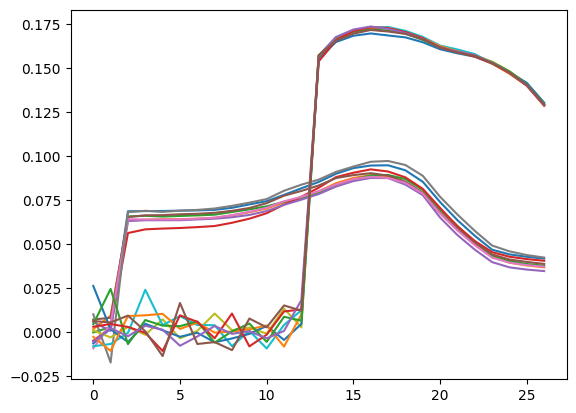

In [29]:
for i in range(1):
    for j in range(2):
        for k in range(seed_lds_array.shape[2]):
            plt.plot(seed_lds_array[i, j, k, 0])

In [30]:
seed_lds_array[:, :, :, 0].max(axis=-1)

array([[[0.09481657, 0.08914359, 0.08931227, 0.09248709, 0.08763782,
         0.09033331, 0.08828068, 0.09726098],
        [0.17320316, 0.17337301, 0.16971327, 0.17286369, 0.17192743,
         0.17329262, 0.17367465, 0.17168456]]])

In [31]:
seed_lds = seed_lds_array[:, :, :, 0].max(axis=-1)[:, :]
seed_lds.shape

(1, 2, 8)

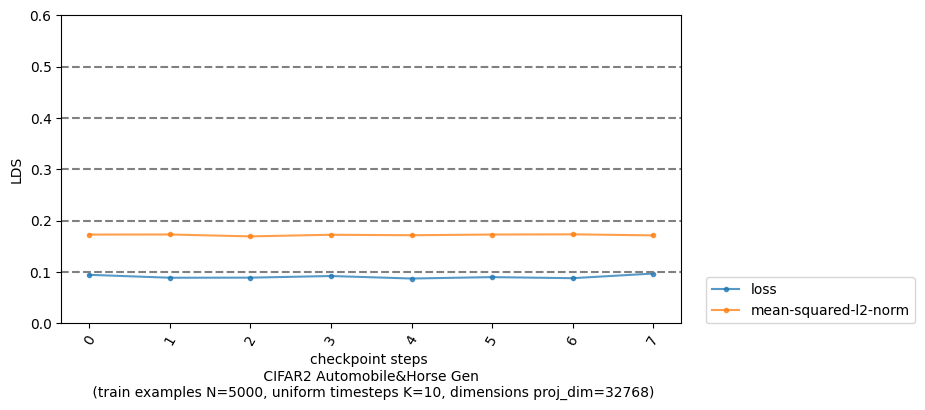

In [32]:
plt.figure(figsize=(8,4))

for idx, f in enumerate(f_name_list):
    plt.plot(ckpt_list, seed_lds[0, idx], label=f, marker='.', alpha=0.75)

plt.xlabel('checkpoint steps \n CIFAR2 Automobile&Horse Gen \n (train examples N=5000, uniform timesteps K=10, dimensions proj_dim=32768)')
plt.ylabel('LDS')
plt.xticks(ticks=ckpt_list, labels=ckpt_list, rotation=60)
plt.ylim(0, 0.6)

plt.axhline(y=0.5, color='gray', linestyle='dashed')
plt.axhline(y=0.4, color='gray', linestyle='dashed')
plt.axhline(y=0.3, color='gray', linestyle='dashed')
plt.axhline(y=0.2, color='gray', linestyle='dashed')
plt.axhline(y=0.1, color='gray', linestyle='dashed')

plt.legend(loc=(1.04, 0))

In [33]:
with open('./gen_5000_0.5_scores_{}.pkl'.format(K), 'wb') as handle:
    pickle.dump(seed_score_list, handle)

In [34]:
len(seed_score_list)

1

In [35]:
len(seed_score_list[0])

2

In [36]:
len(seed_score_list[0][0])

8

In [37]:
seed_score_list[0][0][0].shape

(1000, 5000)

In [38]:
np.stack(seed_score_list[0][0]).mean(axis=0).shape

(1000, 5000)

In [39]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -np.stack(seed_score_list[0][0])[0:8].mean(axis=0)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.094 (avg p value 0.404996)


In [40]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -np.stack(seed_score_list[0][1])[0:8].mean(axis=0)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.180 (avg p value 0.263917)
